
# Python Code Analysis: Simulation of Coherent State Decay

This notebook performs a numerical simulation of the time evolution of a quantum optical state in an optical cavity. We use the Lindblad master equation to model the effect of photon loss (an open quantum system) and compare the results with the analytical solution. Below, we analyze each section of the code.

## 1. Simulation Parameters

```python
N_max = 25
alpha = 2.0
kappa = 0.5
t_max = 10.0
n_steps = 201
```

- **N_max**: This variable determines the dimension of the Hilbert space. Since the Fock space for a quantum harmonic oscillator is infinite-dimensional (|0⟩, |1⟩, |2⟩, ...), we need to truncate it at a certain dimension for numerical simulation. `N_max = 25` means we only consider photon states from |0⟩ to |24⟩. This approximation works very well for coherent states with not-too-large amplitudes (such as `alpha = 2.0` which has an initial mean photon number of |α|² = 4).

- **alpha**: The complex amplitude of the initial coherent state |α⟩. This parameter determines the initial energy stored in the cavity.

- **kappa**: The cavity decay rate, which is exactly the same κ in the master equation. This parameter controls the rate of photon leakage and consequently the rate of energy decay.

- **t_max** and **n_steps**: These variables specify the time range and the number of points for numerically solving the differential equation.

## 2. Operator Definitions

In quantum mechanics, physical observables are represented by operators. Here, we define the creation (a†) and annihilation (a) operators as matrices in the Fock basis.

```python
def annihilation(dim):
    # ...
a = annihilation(N_max)
a_dag = creation(N_max)
n_op = a_dag @ a
```

- **Annihilation operator a**: The effect of this operator on a Fock state |n⟩ is given by a|n⟩ = √n|n-1⟩. This code builds an (N_max, N_max) matrix that represents this operation.

- **Creation operator a_dag**: This operator is the conjugate transpose of the annihilation operator (a†) and its effect is a†|n⟩ = √(n+1)|n+1⟩.

- **Number operator n_op**: This operator is defined as n = a†a, and its expectation value gives us the mean number of photons in the system.

## 3. Initial State

We start the simulation with a pure coherent state. In the density matrix formalism, a pure state |ψ⟩ is represented by the operator ρ = |ψ⟩⟨ψ|.

```python
rho0 = coherent_density_matrix(N_max, alpha)
```

This section of code builds the initial density matrix ρ(0) = |α⟩⟨α| using the definition of coherent states in the Fock basis:

$$
|\alpha\rangle = e^{-|\alpha|^2/2} \sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle
$$

## 4. Lindblad Master Equation

This section is the core of the simulation. The `lindblad_rhs` function calculates the right-hand side of the Lindblad differential equation:

$$
\frac{d\rho}{dt} = \frac{\kappa}{2} (2a\rho a^\dagger - a^\dagger a \rho - \rho a^\dagger a)
$$

```python
def lindblad_rhs(t, rho_flat, a_op, n_op, k):
    # ...
    term1 = 2 * a_op @ rho @ a_op.T.conj() # Corresponds to 2*a*rho*a_dag
    term2 = n_op @ rho                     # Corresponds to n*rho
    term3 = rho @ n_op                     # Corresponds to rho*n
    d_rho_dt = (k / 2) * (term1 - term2 - term3)
    return d_rho_dt.flatten()
```

Each line of this function directly maps to one of the terms in the equation above. We use matrix multiplication (@) to apply the operators to the density matrix ρ. The output of this function is the time derivative of the density matrix, dρ/dt.

## 5. Running the Simulation

To solve the differential equation dρ/dt = f(ρ,t), we use an advanced numerical solver from the SciPy library called `solve_ivp`.

```python
solution = solve_ivp(
    fun=lindblad_rhs,
    t_span=[0, t_max],
    y0=rho0_flat,
    # ...
)
```

This function, by taking the initial state ρ0 and the derivative function `lindblad_rhs`, numerically calculates the density matrix ρ(t) over the time interval `t_span` and stores it in the `solution` variable.

## 6. Processing Results and Plotting

After solving the equation and obtaining ρ(t) at all time points, we need to extract the expectation value of the photon number. This is done using the relation ⟨n(t)⟩ = Tr(ρ(t)n).

```python
n_t_numerical = []
for i in range(len(solution.t)):
    rho_t = solution.y[:, i].reshape((N_max, N_max))
    n_exp_val = np.real(np.trace(rho_t @ n_op))
    n_t_numerical.append(n_exp_val)
```

In this loop, we extract the density matrix ρ_t from the solver results for each time point and calculate the trace of its product with the number operator (n_op).

Finally, we plot the numerically obtained results (`n_t_numerical`) along with the exact analytical solution we derived earlier:

$$
\langle n(t) \rangle_{\text{analytical}} = |\alpha|^2 e^{-\kappa t}
$$

This comparison allows us to verify the accuracy of our simulation. The perfect agreement between the two curves shows that our numerical modeling correctly describes the physical dynamics of the system.

Starting simulation...
Simulation completed successfully.
Plotting results...


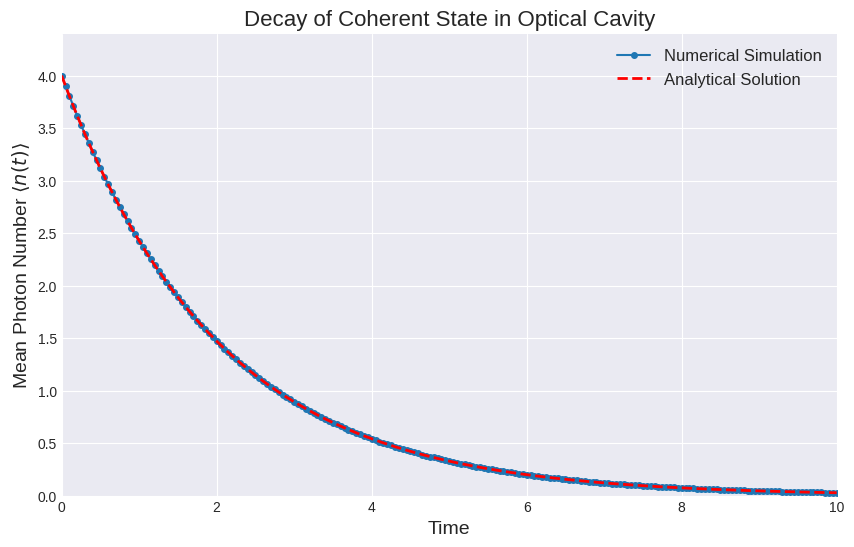

Plot displayed.


In [7]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import factorial
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
# Set the physical parameters for the simulation
N_max = 25          # Hilbert space dimension (truncation of Fock space)
alpha = 2.0         # Amplitude of the initial coherent state
kappa = 0.5         # Cavity decay rate

# Time settings for the simulation
t_max = 10.0        # Maximum simulation time
n_steps = 201       # Number of time steps to evaluate

# --- 2. Operator Definitions ---
# Define quantum operators in the Fock basis

def annihilation(dim):
    """Creates the annihilation operator 'a'."""
    data = np.sqrt(np.arange(1, dim))
    return np.diag(data, 1)

def creation(dim):
    """Creates the creation operator 'a_dag'."""
    return annihilation(dim).T.conj()

# Create operators for the given dimension
a = annihilation(N_max)
a_dag = creation(N_max)
n_op = a_dag @ a  # Number operator n = a_dag * a

# --- 3. Initial State Definition ---
def coherent_state_ket(dim, alpha_val):
    """Creates the ket vector for a coherent state |alpha>."""
    vec = np.zeros(dim, dtype=np.complex128)
    norm_sq = np.abs(alpha_val)**2
    for n_val in range(dim):
        vec[n_val] = np.exp(-norm_sq / 2) * (alpha_val**n_val) / np.sqrt(factorial(n_val))
    return vec

def coherent_density_matrix(dim, alpha_val):
    """Creates the density matrix rho = |alpha><alpha| for a coherent state."""
    ket = coherent_state_ket(dim, alpha_val).reshape(dim, 1)
    bra = ket.T.conj()
    return ket @ bra

# Create the initial density matrix
rho0 = coherent_density_matrix(N_max, alpha)
rho0_flat = rho0.flatten() # Flatten the matrix for the ODE solver

# --- 4. Lindblad Master Equation ---
def lindblad_rhs(t, rho_flat, a_op, n_op, k):
    """
    Calculates the right-hand side of the Lindblad master equation.
    d(rho)/dt = (k/2) * (2*a*rho*a_dag - n*rho - rho*n)
    """
    # Reshape the flat array back into a matrix
    rho = rho_flat.reshape((N_max, N_max))

    # Calculate the terms of the master equation
    term1 = 2 * a_op @ rho @ a_op.T.conj()
    term2 = n_op @ rho
    term3 = rho @ n_op

    # Calculate the time derivative
    d_rho_dt = (k / 2) * (term1 - term2 - term3)

    # Flatten the result for the solver
    return d_rho_dt.flatten()

# --- 5. Run the Simulation ---
print("Starting simulation...")

# Define the time points for evaluation
t_eval = np.linspace(0, t_max, n_steps)

# Use SciPy's ODE solver
# 'solve_ivp' solves the initial value problem for a system of ODEs
solution = solve_ivp(
    fun=lindblad_rhs,
    t_span=[0, t_max],
    y0=rho0_flat,
    t_eval=t_eval,
    args=(a, n_op, kappa),
    method='RK45'  # A standard, robust solver
)

print("Simulation completed successfully.")

# --- 6. Process Results ---
# Calculate the expectation value of the number operator at each time step
n_t_numerical = []
for i in range(len(solution.t)):
    # Reshape the solution vector back to a density matrix
    rho_t = solution.y[:, i].reshape((N_max, N_max))
    
    # Calculate expectation value: <n> = Tr(rho * n)
    # The result should be real, so we take np.real for safety
    n_exp_val = np.real(np.trace(rho_t @ n_op))
    n_t_numerical.append(n_exp_val)

# Calculate the analytical solution for comparison
n0 = np.abs(alpha)**2
n_t_analytical = n0 * np.exp(-kappa * t_eval)

# --- 7. Plotting ---
print("Plotting results...")
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot numerical result
ax.plot(t_eval, n_t_numerical, 'o-', label='Numerical Simulation', markersize=4)

# Plot analytical solution
ax.plot(t_eval, n_t_analytical, '--', label='Analytical Solution', linewidth=2, color='red')

# Set labels and title
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel(r'Mean Photon Number $\langle n(t) \rangle$', fontsize=14)
ax.set_title('Decay of Coherent State in Optical Cavity', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True)

# Adjust plot limits for better visualization
ax.set_xlim(0, t_max)
ax.set_ylim(0, n0 * 1.1)

# Display the plot
plt.savefig('plot_image.png' )
plt.show()

print("Plot displayed.")